In [85]:
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.algorithms.assortativity.correlation import degree_pearson_correlation_coefficient
from networkx.algorithms.bridges import bridges
from networkx.algorithms.connectivity import average_node_connectivity
from networkx.algorithms.efficiency_measures import global_efficiency

### Testing graph analysis

In [2]:
with open('word_pairs.txt') as f:
    data = json.load(f)

In [3]:
G = nx.Graph()
for link in data:
    G.add_edge(link[0][0], link[0][1], weight=link[1])

In [4]:
len(G)

801

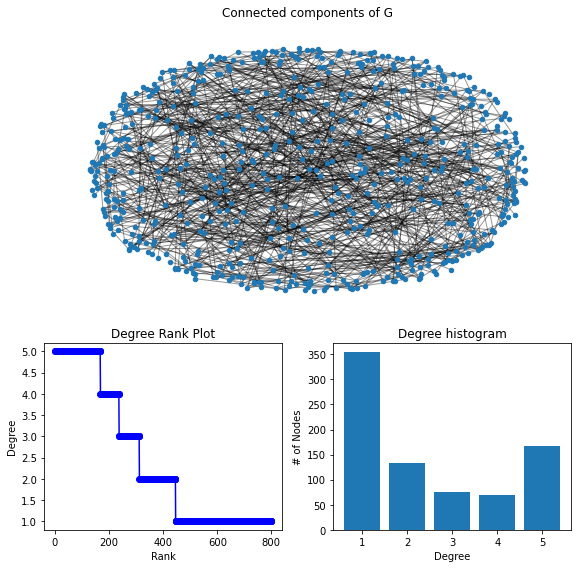

In [5]:
# visualize the example geoscience graph

seed = 13648  # Seed random number generators for reproducibility
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=seed)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


Largest eigenvalue: (2.0000000000000355+0j)
Smallest eigenvalue: (-7.485026177742505e-16+0j)


/Users/davidnoble/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/davidnoble/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


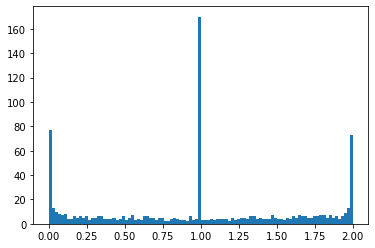

In [6]:
# examine eigenvalues of geoscience KG
L = nx.normalized_laplacian_matrix(G)
e = np.linalg.eigvals(L.toarray())
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
#plt.xlim(0, 2)  # eigenvalues between 0 and 2
plt.show()

In [28]:
def read_graph(path):
    # read in the results of the KG generation method as a networkx graph object
    with open(path) as f:
        data = json.load(f)
    G = nx.Graph()
    for link in data:
        G.add_edge(link[0][0], link[0][1], weight=link[1])
    return G

def analyze_graph(G):
    # compute graph characteristics for input graph object
    result = {}
    result['degree_pearson_correlation_coefficient'] = degree_pearson_correlation_coefficient(G)
    result['num_bridges'] = len(list(bridges(G)))
    result['average_node_connectivity'] = average_node_connectivity(G)
    result['global_efficiency'] = global_efficiency(G)
    return result

In [29]:
geo_base_constituentof = read_graph('geo_results/Base_DistilBert_Geology/MineralConstituentOf/ent_tuples.json')
geo_base_sourcefor = read_graph('geo_results/Base_DistilBert_Geology/MineralSourceFor/ent_tuples.json')
geo_ft_constituentof = read_graph('geo_results/Fine_Tuned_DistilBert_Geology/MineralConstituentOf/ent_tuples.json')
geo_ft_sourcefor = read_graph('geo_results/Fine_Tuned_DistilBert_Geology/MineralSourceFor/ent_tuples.json')

bio_base_causes = read_graph('bio_results/Base_BERT_Bio1/Causes/ent_tuples.json')
bio_base_constituentof = read_graph('bio_results/Base_BERT_Bio1/ConsituentOf/ent_tuples.json')
bio_base_createdby = read_graph('bio_results/Base_BERT_Bio2/CreatedBy/ent_tuples.json')
bio_base_target = read_graph('bio_results/Base_BERT_Bio2/Targets/ent_tuples.json')
bio_ft_causes = read_graph('bio_results/BioBERT_Bio1/Causes/ent_tuples.json')
bio_ft_constituentof = read_graph('bio_results/BioBERT_Bio1/ConsituentOf/ent_tuples.json')
bio_ft_createdby = read_graph('bio_results/BioBERT_Bio2/CreatedBy/ent_tuples.json')
bio_ft_target = read_graph('bio_results/BioBERT_Bio2/Targets/ent_tuples.json')


In [30]:
all_graphs = [
    'geo_base_constituentof', 
    'geo_base_sourcefor', 
    'geo_ft_constituentof', 
    'geo_ft_sourcefor', 
    'bio_base_causes', 
    'bio_base_constituentof', 
    'bio_base_createdby', 
    'bio_base_target', 
    'bio_ft_causes', 
    'bio_ft_constituentof', 
    'bio_ft_createdby', 
    'bio_ft_target'
]

In [44]:
graph_analysis_results = {}
for graph in tqdm(all_graphs):
    graph_analysis_results[graph] = analyze_graph(eval(graph))

  0%|          | 0/12 [00:00<?, ?it/s]

In [90]:
df_graph_results = pd.DataFrame.from_dict(graph_analysis_results).T
#df_graph_results.to_csv('graph_analysis_results.csv')
df_graph_results = df_graph_results.reset_index().rename(columns={'index': 'graph'})
df_graph_results[['subject', 'model', 'relation']] = df_graph_results['graph'].str.extract(r'(.+)_(.+)_(.+)')
df_graph_results = df_graph_results.melt(id_vars=['subject', 'model', 'relation'],
    value_vars=['degree_pearson_correlation_coefficient', 'num_bridges',
        'average_node_connectivity', 'global_efficiency'])
df_graph_results

,subject,model,relation,variable,value
0,geo,base,constituentof,degree_pearson_correlation_coefficient,0.156547
1,geo,base,sourcefor,degree_pearson_correlation_coefficient,-0.025867
2,geo,ft,constituentof,degree_pearson_correlation_coefficient,0.055444
3,geo,ft,sourcefor,degree_pearson_correlation_coefficient,-0.163872
4,bio,base,causes,degree_pearson_correlation_coefficient,-0.159960
5,bio,base,constituentof,degree_pearson_correlation_coefficient,-0.086304
6,bio,base,createdby,degree_pearson_correlation_coefficient,-0.003064
7,bio,base,target,degree_pearson_correlation_coefficient,-0.027760
8,bio,ft,causes,degree_pearson_correlation_coefficient,-0.020325
9,bio,ft,constituentof,degree_pearson_correlation_coefficient,-0.459537


In [122]:
df_geo_graph_results = df_graph_results[df_graph_results['subject'] == 'geo']
df_bio_graph_results = df_graph_results[df_graph_results['subject'] == 'bio']

def plot_graph_characteristics(df):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    sns.barplot(data=df[df['variable'] == 'degree_pearson_correlation_coefficient'],
        x='variable', y='value', hue='model', ax=axs[0, 0])
    sns.barplot(data=df[df['variable'] == 'num_bridges'],
        x='variable', y='value', hue='model', ax=axs[0, 1])
    sns.barplot(data=df[df['variable'] == 'average_node_connectivity'],
        x='variable', y='value', hue='model', ax=axs[1, 0])
    sns.barplot(data=df[df['variable'] == 'global_efficiency'],
        x='variable', y='value', hue='model', ax=axs[1, 1])

    axs[0, 0].set_xlabel('')
    axs[0, 1].set_xlabel('')
    axs[1, 0].set_xlabel('')
    axs[1, 1].set_xlabel('')

    sns.despine()
    return fig


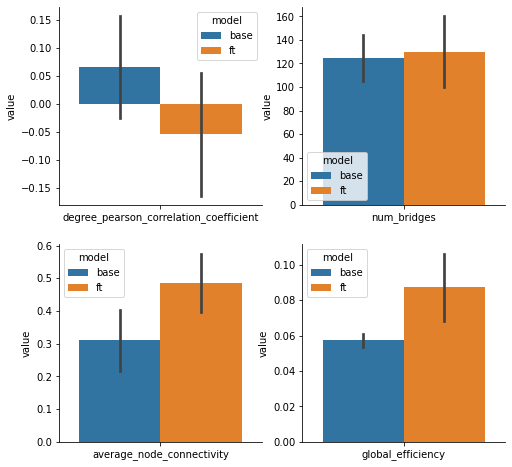

In [123]:
fig = plot_graph_characteristics(df_geo_graph_results)
fig.savefig('plots/geo_graph_analysis', dpi=200, facecolor='white', bbox_inches='tight')

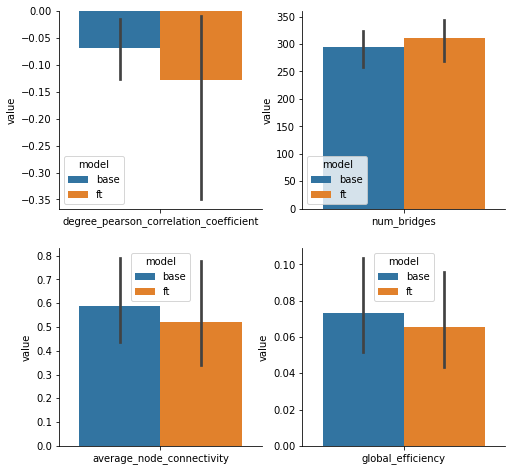

In [124]:
fig = plot_graph_characteristics(df_bio_graph_results)
fig.savefig('plots/bio_graph_analysis', dpi=200, facecolor='white', bbox_inches='tight')

In [121]:
# find proportion of bio-specific terms in each graph
df_bio_terms = pd.read_csv('bio_terms.csv', index_col=0).reset_index(drop=True)
dict_bio_terms = df_bio_terms.set_index('node').to_dict()['domain_relevant']

In [55]:
bio_base_graphs = [bio_base_causes,
    bio_base_constituentof,
    bio_base_createdby,
    bio_base_target]
    
bio_ft_graphs = [bio_ft_causes,
bio_ft_constituentof,
bio_ft_createdby,
bio_ft_target]

In [74]:
bio_base_terms = [x for x in [list(g.nodes) for g in bio_base_graphs]][0]
bio_ft_terms = [x for x in [list(g.nodes) for g in bio_ft_graphs]][0]

bio_base_terms_dr = [dict_bio_terms[term] for term in bio_base_terms if term in dict_bio_terms]
bio_ft_terms_dr = [dict_bio_terms[term] for term in bio_ft_terms if term in dict_bio_terms]

print('Bio Base domain relevant proportion:\t\t', np.mean(bio_base_terms_dr))
print('Bio Fine-Tuned domain relevant proportion:\t',np.mean(bio_ft_terms_dr))

Bio Base domain relevant proportion:		 0.532051282051282
Bio Fine-Tuned domain relevant proportion:	 0.9809725158562368
